In [40]:
!pip install pandas seaborn scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

# **Практическое задание №4 Загрядский Р.Д. БПИ-23-1**

# Задачи:

1. Преобразовать датасет (процессинг категориальных признаков, копия данных в df_not_processed, scale датасета)
2. Сделать k-means кластеризацию (записать cluster в df_not_processed, вывести статистику, графики. попробовать объяснить принцип кластеризации), оценить метриками, вывести результат
3. Подобрать оптимальное число кластеров с помощью "метод локтя", вывести статистику, графики, метрики, объяснить результат
4. Сделать DBSSCAN кластеризацию, подобрать оптимальные параметры, посчитать метрики, вывести статистику, объяснить результат
5. Ответить на вопрос - какой из методов кластеризации больше подходит для вашего датасета

In [41]:
df = pd.read_csv('/Customers.csv')

In [42]:
df_not_processed = df.copy()
print("Размерность:", df.shape, "\n")
print("Типы:\n", df.dtypes, "\n")
print("Пропуски:\n", df.isna().sum(), "\n")

Размерность: (2000, 8) 

Типы:
 CustomerID                 int64
Gender                    object
Age                        int64
Annual Income ($)          int64
Spending Score (1-100)     int64
Profession                object
Work Experience            int64
Family Size                int64
dtype: object 

Пропуски:
 CustomerID                 0
Gender                     0
Age                        0
Annual Income ($)          0
Spending Score (1-100)     0
Profession                35
Work Experience            0
Family Size                0
dtype: int64 



### **1. Преобразование датасета**:

Начнем с того, что заполним все пропуски в столбце Profession, удалим ненужный столбец и преобразуем категориальные признаки в тип данных category

Затем выберем числовые признаки, проведем копия данных в df_not_processed, scale датасета и применем нормализацию

In [43]:
df["Profession"] = df["Profession"].fillna("Unknown")
df.drop(columns=['CustomerID'], inplace=True)
df["Gender"] = df["Gender"].astype("category")
df["Profession"] = df["Profession"].astype("category")
category_columns: list[str] = df.select_dtypes(include=['category']).columns
df = pd.get_dummies(df, columns=category_columns, drop_first=True)
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])
print("Преобразованная форма данных:", df.shape)
display(df.head())

Преобразованная форма данных: (2000, 15)


,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size,Gender_Male,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Profession_Unknown
0,-1.054089,-2.093501,-0.428339,-0.791207,0.117497,True,False,False,False,False,True,False,False,False,False
1,-0.983723,-1.656133,1.075546,-0.281162,-0.390051,True,False,True,False,False,False,False,False,False,False
2,-1.018906,-0.540845,-1.609962,-0.791207,-1.405148,False,False,True,False,False,False,False,False,False,False
3,-0.913356,-1.131292,0.932319,-1.046230,-0.897599,False,False,False,False,False,False,False,True,False,False
4,-0.631891,-1.590528,-0.392532,-0.536185,1.132594,False,False,False,True,False,False,False,False,False,False


### **2. KMeans кластеризация**

K-Means — это алгоритм для разбиения данных на заранее заданное количество групп (кластеров) (K). Он циклично выполняет три действия: случайно выбирает центры групп(центроиды), распределяет все объекты по ближайшему центру, а затем заново вычисляет положение этих центров. Процесс останавливается, когда центры групп перестают смещаться. Лучше всего алгоритм работает, когда настоящие группы данных похожи на сферы. Чтобы найти подходящее число групп K, используется «метод локтя»: он помогает найти значение, после которого дальнейшее увеличение числа групп почти не улучшает качество группировки.

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Первым делом мы запишем кластеры в копию,выведем метрики и график

Silhouette Score: 0.127
Calinski–Harabasz Index: 289.5
Davies–Bouldin Index: 2.112


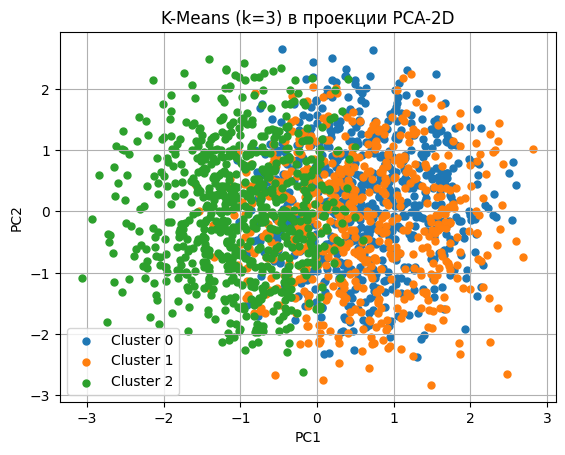

In [45]:
k_base = 3
km = KMeans(n_clusters=k_base, n_init=10, random_state=42)
labels_km = km.fit_predict(df)
df_not_processed['cluster_kmeans_base'] = labels_km
sil = silhouette_score(df, labels_km)
ch  = calinski_harabasz_score(df, labels_km)
db  = davies_bouldin_score(df, labels_km)

print(f"Silhouette Score: {sil:.3f}")
print(f"Calinski–Harabasz Index: {ch:.1f}")
print(f"Davies–Bouldin Index: {db:.3f}")

pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(df)

for lab in np.unique(labels_km):
    mask = labels_km == lab
    plt.scatter(X2[mask, 0], X2[mask, 1], s=25, label=f'Cluster {lab}')
plt.title(f'K-Means (k={k_base}) в проекции PCA-2D')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
sizes = (
    df_not_processed['cluster_kmeans_base']
    .value_counts()
    .rename_axis('cluster')
    .reset_index(name='size')
    .sort_values('cluster')
)
display(sizes)

,cluster,size
1,0,675
2,1,607
0,2,718


Далее выведем средние значение числовых признаков и распределение категориальных признаков

In [47]:

num_cols = ['Age', 'Annual Income ($)', 'Spending Score (1-100)', 'Work Experience', 'Family Size']
df_not_processed.groupby('cluster_kmeans_base')[num_cols].mean().round(1)

,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size
cluster_kmeans_base,,,,,
0,52.7,123012.8,53.0,2.7,5.8
1,48.2,119574.6,45.9,8.7,3.3
2,46.1,91710.6,53.3,1.6,2.3


In [48]:
pd.crosstab(df_not_processed['cluster_kmeans_base'], df_not_processed['Gender'], normalize='index').round(2)

Gender,Female,Male
cluster_kmeans_base,,
0,0.60,0.40
1,0.58,0.42
2,0.60,0.40


In [49]:
pd.crosstab(df_not_processed['cluster_kmeans_base'], df_not_processed['Profession'], normalize='index').round(2)

Profession,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing
cluster_kmeans_base,,,,,,,,,
0,0.27,0.08,0.10,0.14,0.08,0.18,0.02,0.08,0.04
1,0.32,0.08,0.09,0.10,0.08,0.17,0.05,0.06,0.05
2,0.34,0.09,0.09,0.11,0.07,0.17,0.02,0.07,0.04


Алгоритм разделил клиентов на три основные группы. Кластер 0 — это старшее поколение с высоким доходом, возможно, владельцы бизнеса. Кластер 1 — самая опытная и сбалансированная группа со средними показателями. Кластер 2 — молодежь с небольшим доходом, но высокими тратами.

В целом, разделение в основном проходит по возрасту, доходу и стажу, но четких границ между группами нет. Такие факторы, как пол и профессия, почти не влияют на то, в какую группу попадает клиент.

K-Means с тремя кластерами показал слабый результат. Низкие метрики качества и визуальное наложение кластеров на графике означают, что алгоритм не нашёл чётких, отдельных групп. Хотя между кластерами есть небольшие различия в возрасте, доходе и стаже, они слишком размыты. Пол и профессия клиентов вообще не повлияли на разделение. В целом, эти три кластера плохо описывают реальную структуру данных.

### **3. Метод локтя**

**Подберем число кластеров, выведем график метода локтя и график силуэта**

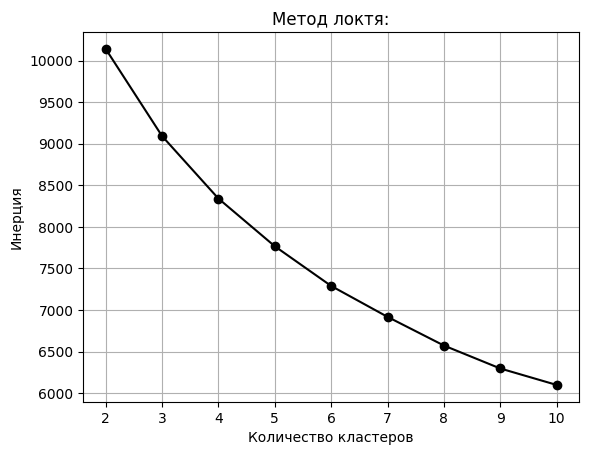

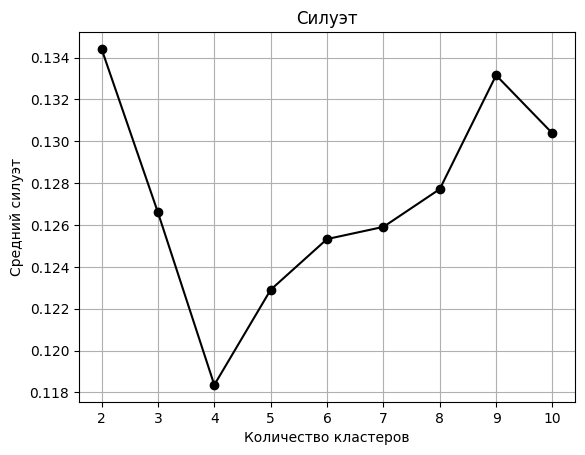

In [50]:
k_values = list(range(2, 11))
inertias, silhouettes = [], []
labels_by_k = {}
for k in k_values:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(df)
    labels_by_k[k] = labels
    inertias.append(km.inertia_)
    try:
        silhouettes.append(silhouette_score(df, labels))
    except Exception:
        silhouettes.append(np.nan)
plt.plot(k_values, inertias, marker='o', color='black')
plt.title('Метод локтя:')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.grid(True)
plt.show()

plt.plot(k_values, silhouettes, marker='o',color='black')
plt.title('Силуэт')
plt.xlabel('Количество кластеров')
plt.ylabel('Средний силуэт')
plt.grid(True)
plt.show()


Метод локтя не дал чёткого ответа, однако анализ силуэта показал, что оптимальное количество кластеров — два. При k=2 достигается наилучший баланс: кластеры получаются плотными и в то же время хорошо отделены друг от друга.

**Теперь делаем кластеризацию с оптимальным количеством**

[k=2] Silhouette=0.134 | CH=312.9 | DB=2.451


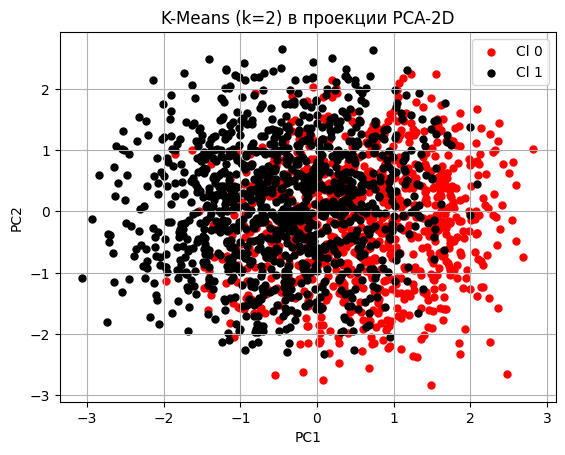

In [51]:
best_k = 2
km_opt = KMeans(n_clusters=best_k, n_init=10, random_state=42).fit(df)
labels_opt = km_opt.labels_
df_not_processed['cluster_kmeans_opt'] = labels_opt
sil_opt = silhouette_score(df, labels_opt)
ch_opt  = calinski_harabasz_score(df, labels_opt)
db_opt  = davies_bouldin_score(df, labels_opt)
print(f'[k={best_k}] Silhouette={sil_opt:.3f} | CH={ch_opt:.1f} | DB={db_opt:.3f}')
X2 = PCA(n_components=2, random_state=42).fit_transform(df)
colors = ['red', 'black']
for i, lab in enumerate(np.unique(labels_opt)):
    m = labels_opt == lab
    plt.scatter(X2[m,0], X2[m,1], s=25, color=colors[i], label=f'Cl {lab}')
plt.title(f'K-Means (k={best_k}) в проекции PCA-2D')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(); plt.grid(True); plt.show()

In [52]:
sizes = (
    df_not_processed['cluster_kmeans_opt']
    .value_counts()
    .rename_axis('cluster')
    .reset_index(name='size')
    .sort_values('cluster')
)
display(sizes)

,cluster,size
1,0,846
0,1,1154


Далее выведем средние значение числовых признаков и распределение категориальных признаков

In [53]:
num_cols = ['Age', 'Annual Income ($)', 'Spending Score (1-100)', 'Work Experience', 'Family Size']
df_not_processed.groupby('cluster_kmeans_opt')[num_cols].mean().round(1)

,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size
cluster_kmeans_opt,,,,,
0,48.6,118714.1,49.0,8.1,3.9
1,49.2,104880.0,52.4,1.2,3.7


In [54]:
pd.crosstab(df_not_processed['cluster_kmeans_opt'], df_not_processed['Gender'], normalize='index').round(2)

Gender,Female,Male
cluster_kmeans_opt,,
0,0.58,0.42
1,0.60,0.40


In [55]:
pd.crosstab(df_not_processed['cluster_kmeans_opt'], df_not_processed['Profession'], normalize='index').round(2)

Profession,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing
cluster_kmeans_opt,,,,,,,,,
0,0.32,0.08,0.09,0.10,0.09,0.17,0.05,0.06,0.05
1,0.31,0.08,0.09,0.14,0.07,0.17,0.02,0.08,0.04


K-Means с двумя кластерами выявил более чёткое разделение клиентов. Первая группа — это состоятельные и опытные клиенты, которые тратят деньги более рационально. Вторая группа — напротив, клиенты с меньшим доходом и практически без опыта, но склонные к slightly более высоким тратам.

Таким образом, основное различие между группами проходит по уровню дохода и профессиональному стажу, что делает кластеры более интерпретируемыми по сравнению с разделением на три группы. Однако другие характеристики всё ещё недостаточно чётко разделяют клиентов.

Оптимальным количеством кластеров оказалось k=2, однако и такое разделение нельзя назвать качественным. Метрики остаются низкими, а на графике видно сильное перекрытие кластеров. Алгоритм в основном разделил клиентов по опыту работы и размеру семьи, но эти различия недостаточно выражены. Пол и профессия по-прежнему не влияют на группировку. В целом, данные плохо поддаются кластеризации K-Means, вероятно, из-за отсутствия чётких естественных группировок или сложной структуры данных.

**Сравнение**

При базовом числе k = 3 алгоритм выделил три группы клиентов, однако полученные метрики (Silhouette ≈ 0.13, Davies–Bouldin ≈ 2.1) показали слабое разделение между кластерами. Анализ средних значений признаков подтвердил, что различия между группами незначительны, а на PCA-графике наблюдается существенное перекрытие точек.

Разделение на два кластера даёт немного лучшее качество, хотя кластеры по-прежнему пересекаются.

Таким образом, можно сделать вывод, что данные не имеют ярко выраженной кластерной структуры, а K-Means не способен сформировать чёткие и компактные группы. Тем не менее, k = 2 можно считать условно оптимальным числом кластеров, поскольку оно обеспечивает наилучший баланс между простотой модели и метриками качества.

**Итоговый** **вывод**:

Сравнение кластеризации с разным количеством кластеров показало, что исходные данные не имеют чёткой структуры. При k=3 алгоритм выделил слаборазличимые группы с невысокими метриками качества (Silhouette ≈ 0.13) и значительным перекрытием на графике. Разделение на два кластера (k=2) дало условно лучший результат, однако кластеры всё равно остаются размытыми. Таким образом, K-Means не выявил в данных явных естественных группировок, но k=2 можно считать оптимальным компромиссом, обеспечивающим наиболее интерпретируемое, хотя и неидеальное, разделение.

## DBSCAN

In [56]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_db = dbscan.fit_predict(df)
np.unique(labels_db, return_counts=True)

(array([-1]), array([2000]))

Построим график k-расстояний для k=10

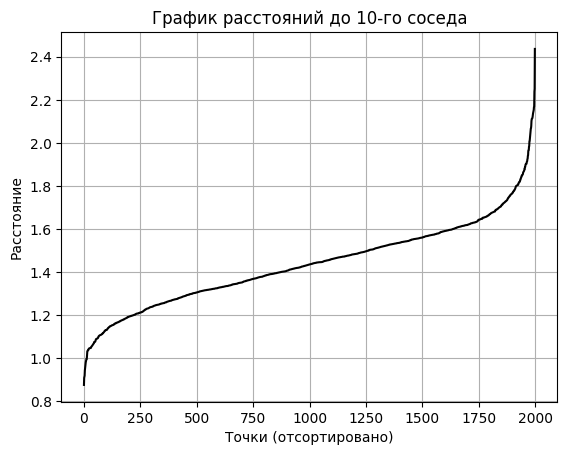

In [57]:
k_distance = 10
nn_k = NearestNeighbors(n_neighbors=k_distance)
nn_k.fit(df)
distances_k, indices_k = nn_k.kneighbors(df)
distances_k = np.sort(distances_k[:, k_distance-1])
plt.plot(distances_k, color='black')
plt.title(f'График расстояний до {k_distance}-го соседа')
plt.xlabel('Точки (отсортировано)')
plt.ylabel('Расстояние')
plt.grid(True)
plt.show()

# Перебор min_samples и eps для DBSCAN

In [58]:
min_samples_values = range(5, 21, 5)
eps_values = [0.5, 0.8, 1.0, 1.3, 1.5, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.4]
for min_samples in min_samples_values:
    print(f"\n--- min_samples = {min_samples} ---")
    for eps in eps_values:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(df)
        n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
        n_noise = (db.labels_ == -1).sum()
        print(f"  eps={eps:.1f}: clusters={n_clusters}, noise={n_noise}")


--- min_samples = 5 ---
  eps=0.5: clusters=0, noise=2000
  eps=0.8: clusters=16, noise=1896
  eps=1.0: clusters=31, noise=1546
  eps=1.3: clusters=2, noise=298
  eps=1.5: clusters=1, noise=47
  eps=1.7: clusters=1, noise=13
  eps=1.8: clusters=1, noise=7
  eps=1.9: clusters=1, noise=2
  eps=2.0: clusters=1, noise=0
  eps=2.1: clusters=1, noise=0
  eps=2.2: clusters=1, noise=0
  eps=2.4: clusters=1, noise=0

--- min_samples = 10 ---
  eps=0.5: clusters=0, noise=2000
  eps=0.8: clusters=0, noise=2000
  eps=1.0: clusters=2, noise=1952
  eps=1.3: clusters=3, noise=667
  eps=1.5: clusters=1, noise=102
  eps=1.7: clusters=1, noise=22
  eps=1.8: clusters=1, noise=10
  eps=1.9: clusters=1, noise=4
  eps=2.0: clusters=1, noise=0
  eps=2.1: clusters=1, noise=0
  eps=2.2: clusters=1, noise=0
  eps=2.4: clusters=1, noise=0

--- min_samples = 15 ---
  eps=0.5: clusters=0, noise=2000
  eps=0.8: clusters=0, noise=2000
  eps=1.0: clusters=0, noise=2000
  eps=1.3: clusters=1, noise=1010
  eps=1.5: cl

Единственные нормальные параметры выявлены - eps=1.3, min_samples = 5

In [59]:
db = DBSCAN(eps=1.3, min_samples=5).fit(df)
df_not_processed['cluster_dbscan'] = db.labels_

Выводим метрики

In [60]:
# Метрики
mask = db.labels_ != -1
sil = silhouette_score(df[mask], db.labels_[mask])
ch  = calinski_harabasz_score(df[mask], db.labels_[mask])
dbi = davies_bouldin_score(df[mask], db.labels_[mask])
print(f"Silhouette={sil:.3f}, CH={ch:.1f}, DB={dbi:.3f}")

Silhouette=0.101, CH=4.4, DB=1.032


Метрики показывают крайне слабое разделение кластеров. Значение Silhouette Score (0.101) близко к нулю, что свидетельствует о значительном перекрытии кластеров. Низкий Calinski-Harabasz Score (4.4) подтверждает минимальные различия между кластерами. Единственный относительно хороший результат — Davies-Bouldin Index (1.032), значительно лучше, чем у K-Means (2.4), но и это значение указывает на неидеальное разделение.

Вероятно, причина в том, что данные содержат две слабовыраженные группы. Результат немного лучше, чем у K-Means, особенно по индексу Davies-Bouldin (<1.1), который указывает на более плотные и чёткие кластеры. Однако общая картина остаётся размытой: низкие значения Silhouette Score и Calinski-Harabasz Index указывают на отсутствие ярко выраженных естественных группировок в данных. Главное преимущество DBSCAN в этой ситуации — его способность идентифицировать выбросы, что делает модель более подходящей для работы с зашумленными данными.

In [61]:
sizes = (
    df_not_processed['cluster_dbscan']
    .value_counts()
    .rename_axis('cluster')
    .reset_index(name='size')
    .sort_values('cluster')
)
display(sizes)

,cluster,size
1,-1,298
0,0,1699
2,1,3


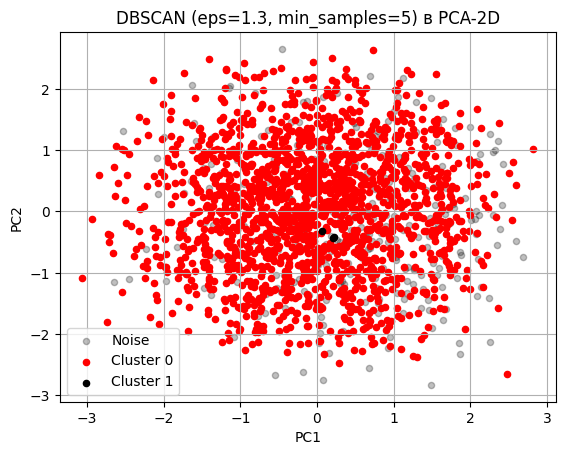

In [62]:
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(df)
colors = ['red', 'black']
for lab in np.unique(db.labels_):
    mask = db.labels_ == lab
    if lab == -1:
        plt.scatter(X2[mask,0], X2[mask,1], s=20, alpha=0.25, color='black', label='Noise')
    else:
        plt.scatter(X2[mask,0], X2[mask,1], s=20, color=colors[lab], label=f'Cluster {lab}')
plt.title('DBSCAN (eps=1.3, min_samples=5) в PCA-2D')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(); plt.grid(True); plt.show()

Алгоритм обнаружил два кластера: один значительный по численности и второй, включающий всего три элемента, что явно недостаточно для формирования полноценной группы.

In [63]:
num_cols = ['Age', 'Annual Income ($)', 'Spending Score (1-100)', 'Work Experience', 'Family Size']
df_not_processed.groupby('cluster_dbscan')[num_cols].mean().round(1)

,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size
cluster_dbscan,,,,,
-1,45.0,110028.4,47.9,7.2,4.1
0,49.7,110734.2,51.6,3.6,3.7
1,16.3,179276.0,13.3,5.0,1.0


In [64]:
pd.crosstab(df_not_processed['cluster_dbscan'], df_not_processed['Gender'], normalize='index').round(2)
pd.crosstab(df_not_processed['cluster_dbscan'], df_not_processed['Profession'], normalize='index').round(2)

Profession,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing
cluster_dbscan,,,,,,,,,
-1,0.07,0.18,0.11,0.12,0.12,0.08,0.09,0.13,0.11
0,0.35,0.06,0.09,0.12,0.07,0.19,0.02,0.06,0.03
1,0.67,0.00,0.33,0.00,0.00,0.00,0.00,0.00,0.00


Кластер 1 из 3 точек представляет собой не реальную группу, а аномальный выброс, включающий несколько "уникальных" объектов, случайно оказавшихся рядом. По сути, алгоритм DBSCAN выявил только один значимый кластер и область шума, а не полноценное разделение на две устойчивые группы.

При изменении параметра eps все данные объединяются в один кластер.

### **K-Means vs DBSCAN**

Для данного набора данных, включающего возраст, доход, траты и другие характеристики клиентов, алгоритм K-Means оказался более эффективным, чем DBSCAN. Он разделил клиентов на две примерно равные группы, хотя и с умеренными метрическими показателями (Silhouette ≈ 0.13).

Алгоритм DBSCAN не подошел так хорошо, поскольку при различных параметрах почти весь набор данных формировал один кластер. Это указывает на равномерное распределение признаков без выраженных плотных областей.

Таким образом, для данного датасета предпочтительнее использовать K-Means, так как он позволяет выявить хотя бы некоторые закономерности между клиентами.